<a href="https://colab.research.google.com/github/yohei0408/no.2/blob/main/%E7%94%BB%E5%83%8F%E3%81%AE%E3%82%AF%E3%83%A9%E3%82%B9%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torchmetrics==0.11.4 pytorch_lightning==2.0.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 25.6 MB/s eta 0:00:00


In [ ]:
import torchmetrics
from torchmetrics.functional import accuracy
torchmetrics.__version__

'0.11.4'

In [ ]:
import pytorch_lightning as pl
pl.__version__

'2.0.2'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision import datasets
import torchsummary
from torchsummary import summary
from pytorch_lightning.loggers import CSVLogger

In [ ]:
# データセットの変換を定義
transform = transforms.Compose([
  transforms.ToTensor()
])

# データセットの取得
train_val = datasets.MNIST('./', train=True, download=True, transform=transform)
test = datasets.MNIST('./', train=False, download=True, transform=transform)

In [ ]:
# サンプルサイズの確認
len(train_val), len(test)

(60000, 10000)

In [ ]:
# train と val に分割
n_train = 50000
n_val = 10000

torch.manual_seed(0)
train, val = torch.utils.data.random_split(train_val, [n_train, n_val])

In [ ]:
len(train), len(val)

(50000, 10000)

In [ ]:
# 入力値の確認
train[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
import matplotlib.pyplot as plt

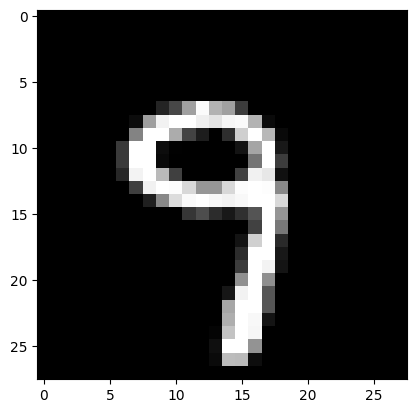

In [ ]:
plt.imshow(train[0][0].reshape(28,28),cmap='gray')

In [ ]:
train[0][1]

9

In [ ]:
batch_size = 1024

In [ ]:
tran_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

In [ ]:
pl.seed_everything(0)

transform = transforms.Compose([transforms.ToTensor()])
train_val = datasets.MNIST('./', train=True, download=True, transform=transform)
test = datasets.MNIST('./',train=False, download=True, transform=transform)

n_train = 50000
n_val = 10000
train, val = torch.utils.data.random_split(train_val, [n_train, n_val])

batch_size = 1024

train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [ ]:
class Net(pl.LightningModule):
  def __init__(self):
    super().__init__()

    self.conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)
    self.bn = nn.BatchNorm2d(3)
    self.fc = nn.Linear(588,10)

  def forward(self, x):
    h = self.conv(x)
    h = F.relu(h)
    h = self.bn(h)
    h = F.max_pool2d(h, kernel_size=2, stride=2)
    h = h.view(-1, 588)
    h = self.fc(h)
    return h

  def training_step(self, batch, batch_idx):
    x, t = batch
    y = self(x)
    loss = F.cross_entropy(y,t)
    self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
    self.log('train_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=10, top_k=1), on_step=True, on_epoch=True, prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x,t = batch
    y = self(x)
    loss = F.cross_entropy(y,t)
    self.log('val_loss', loss, on_step=False, on_epoch=True)
    self.log('val_acc', accuracy(y.softmax(dim=-1), t, task='multiclass',num_classes=10, top_k=1),on_step=False, on_epoch=True)
    return loss

  def test_step(self, batch, batch_idx):
    x,t = batch
    y = self(x)
    loss = F.cross_entropy(y, t)
    self.log('test_loss', loss, on_step=False, on_epoch=True)
    self.log('test_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=10, top_k=1), on_step=False, on_epoch=True)
    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
    return optimizer

In [ ]:
pl.seed_everything(0)
net = Net()
logger = CSVLogger(save_dir='logs', name='my_exp')
trainer = pl.Trainer(max_epochs=20, accelerator='gpu', deterministic=False, logger=logger)
trainer.fit(net, train_loader, val_loader)

INFO:lightning_fabric.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/my_exp/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type        | Params
-------------------------------------
0 | conv | Conv2d      | 30    
1 | bn   | BatchNorm2d | 6     
2 | fc   | Linear      | 5.9 K 
-------------------------------------
5.9 K     Trainable 

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


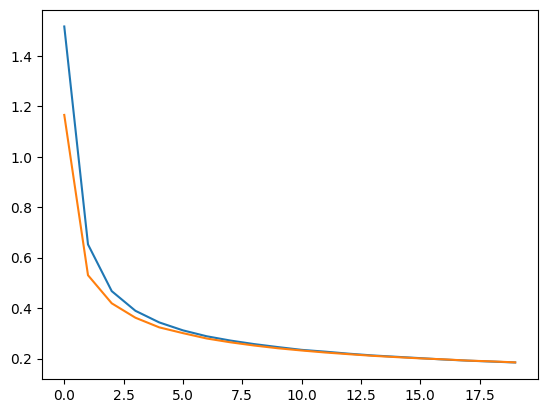

In [ ]:
log = pd.read_csv('/content/logs/my_exp/version_0/metrics.csv')
log[['train_loss_epoch','epoch']].dropna(how='any',axis=0).reset_index()['train_loss_epoch'].plot();
log[['val_loss','epoch']].dropna(how='any',axis=0).reset_index()['val_loss'].plot();

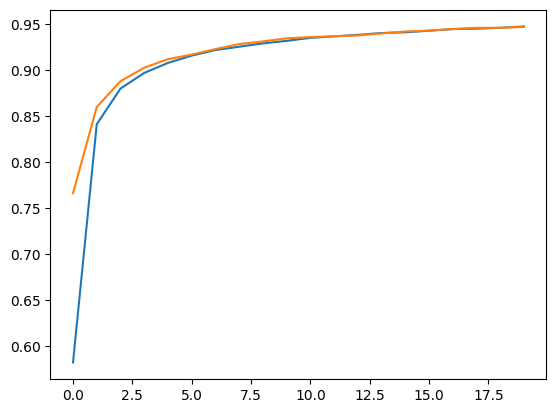

In [ ]:
log[['train_acc_epoch','epoch']].dropna(how='any',axis=0).reset_index()['train_acc_epoch'].plot();
log[['val_acc','epoch']].dropna(how='any', axis=0).reset_index()['val_acc'].plot();

In [ ]:

# テストデータで検証
results = trainer.test(dataloaders=test_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/my_exp/version_0/checkpoints/epoch=19-step=960-v1.ckpt
/usr/local/lib/python3.10/dist-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future r

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9516000151634216     │
│         test_loss         │     0.168410524725914     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
torch.save(net.state_dict(), 'mnist.pt')
net = Net().cpu().eval()
net.load_state_dict(torch.load('mnist.pt', map_location=torch.device('cpu')))
x, t = test[0]
y = net(x.unsqueeze(0))
print(f'y予測値：{y}')
y = F.softmax(y)
print(f'y確率：{y}')
y = torch.argmax(y)
print(f'y予測ラベル：{y}')
print(f't:：{t}')

y予測値：tensor([[-0.6494, -8.0529, -0.2501,  2.5937, -4.3231, -1.0231, -6.4718, 11.9235,
         -0.1292,  4.4455]], grad_fn=<AddmmBackward0>)
y確率：tensor([[3.4625e-06, 2.1090e-09, 5.1617e-06, 8.8685e-05, 8.7884e-08, 2.3827e-06,
         1.0250e-08, 9.9933e-01, 5.8248e-06, 5.6500e-04]],
       grad_fn=<SoftmaxBackward0>)
y予測ラベル：7
t:：7


<ipython-input-44-0dc71b0bfb40>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('mnist.pt', map_location=torch.device('cpu')))
<ipython-input

In [ ]:
train_val = datasets.FashionMNIST('./', train=True, download=True, transform=transform)
test = datasets.FashionMNIST('./', train=False, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:10<00:00, 2557095.15it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 197840.42it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1292321.07it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6001188.71it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
# サンプルサイズの確認
len(train_val), len(test)

(60000, 10000)

In [ ]:
pl.seed_everything(0)

# データセットの変換を定義
transform = transforms.Compose([
  transforms.ToTensor()
])
# データセットの取得
train_val = datasets.FashionMNIST('./', train=True, download=True, transform=transform)
test = datasets.FashionMNIST('./', train=False, download=True, transform=transform)

# train と val に分割
n_train = 50000
n_val = 10000
train, val = torch.utils.data.random_split(train_val, [n_train, n_val])

# バッチサイズの定義
batch_size = 1024

# Data Loader を定義
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val, batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size)

INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [ ]:
 class Net(pl.LightningModule):
  def __init__(self):
    super().__init__()

    self.conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.bn = nn.BatchNorm2d(32)
    self.fc1 = nn.Linear(14*14*32,300)
    self.fc2 = nn.Linear(300,10)

  def forward(self, x):
    h = self.conv(x)
    h = F.relu(self.bn(h))
    h = F.max_pool2d(h, kernel_size=2, stride=2)
    h = h.view(h.size(0),-1)
    h = F.relu(self.fc1(h))
    h = self.fc2(h)
    return h

  def training_step(self, batch, batch_idx):
    x, t = batch
    y = self(x)
    loss = F.cross_entropy(y,t)
    self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
    self.log('train_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=10, top_k=1), on_step=True, on_epoch=True, prog_bar=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x,t = batch
    y = self(x)
    loss = F.cross_entropy(y,t)
    self.log('val_loss', loss, on_step=False, on_epoch=True)
    self.log('val_acc', accuracy(y.softmax(dim=-1), t, task='multiclass',num_classes=10, top_k=1),on_step=False, on_epoch=True)
    return loss

  def test_step(self, batch, batch_idx):
    x,t = batch
    y = self(x)
    loss = F.cross_entropy(y, t)
    self.log('test_loss', loss, on_step=False, on_epoch=True)
    self.log('test_acc', accuracy(y.softmax(dim=-1), t, task='multiclass', num_classes=10, top_k=1), on_step=False, on_epoch=True)
    return loss

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
    return optimizer

In [ ]:
# 学習の実行
pl.seed_everything(0)
net = Net()
logger = CSVLogger(save_dir='logs', name='my_exp')
trainer = pl.Trainer(max_epochs=30, accelerator="gpu", deterministic=False, logger=logger)
trainer.fit(net, train_loader, val_loader)

INFO:lightning_fabric.utilities.seed:Global seed set to 0
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/my_exp/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type        | Params
-------------------------------------
0 | conv | Conv2d      | 320   
1 | bn   | BatchNorm2d | 64    
2 | fc1  | Linear      | 1.9 M 
3 | fc2  | Linear      | 3.0 K 
--------------------------

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


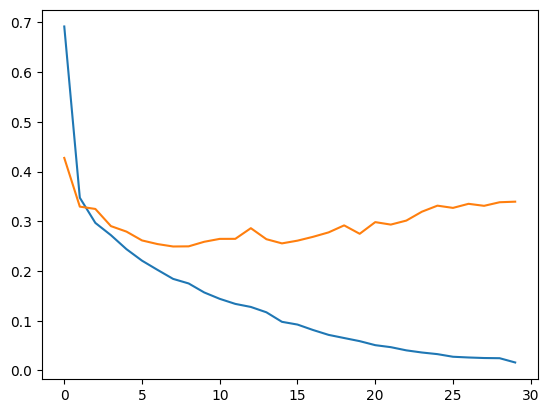

In [ ]:
log = pd.read_csv('/content/logs/my_exp/version_0/metrics.csv')
log[['train_loss_epoch','epoch']].dropna(how='any',axis=0).reset_index()['train_loss_epoch'].plot();
log[['val_loss','epoch']].dropna(how='any',axis=0).reset_index()['val_loss'].plot();

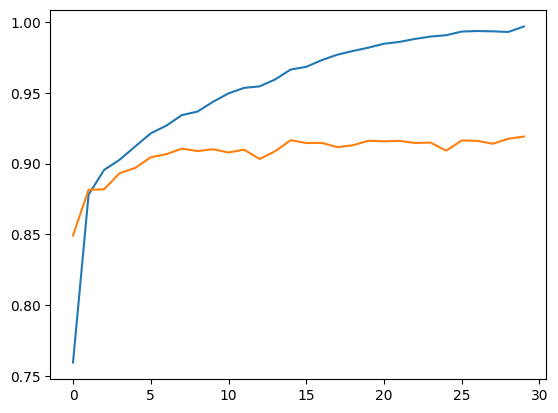

In [ ]:
log[['train_acc_epoch','epoch']].dropna(how='any',axis=0).reset_index()['train_acc_epoch'].plot();
log[['val_acc','epoch']].dropna(how='any', axis=0).reset_index()['val_acc'].plot();

In [ ]:
# テストデータで検証
trainer.test(dataloaders=test_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at logs/my_exp/version_0/checkpoints/epoch=29-step=1440.ckpt
/usr/local/lib/python3.10/dist-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future rel

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9182000160217285     │
│         test_loss         │    0.36107149720191956    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.36107149720191956, 'test_acc': 0.9182000160217285}]

In [ ]:
# 学習済みモデルの保存
torch.save(net.state_dict(), 'mnist.pt')
# ネットワークの準備

net = Net().cpu().eval()
# 重みの読み込み
net.load_state_dict(torch.load('mnist.pt', map_location=torch.device('cpu')))

<ipython-input-74-ace7eba50937>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('mnist.pt', map_location=torch.device('cpu')))


<All keys matched successfully>

In [ ]:
y_all = []  # すべての予測結果を格納するリスト

for x, t in test:  # test データセット全体をループ
    y = net(x.unsqueeze(0))  # ネットワークで予測
    y = F.softmax(y, dim=1)  # ソフトマックス関数で確率に変換
    y_label = torch.argmax(y, dim=1)  # 最も高い確率のラベルを予測
    y_all.append(y_label.item())  # 予測ラベルをリストに追加



# すべての予測ラベルが y_all に格納されています
print(f'全ての予測結果: {y_all}')


全ての予測結果: [9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 5, 1, 6, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 6, 7, 6, 7, 2, 1, 6, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5, 1, 1, 2, 3, 7, 8, 7, 0, 2, 6, 4, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 2, 5, 3, 6, 7, 1, 8, 0, 1, 4, 2, 3, 6, 7, 6, 7, 8, 5, 9, 9, 4, 2, 5, 7, 0, 5, 2, 8, 6, 7, 8, 0, 0, 9, 9, 3, 0, 8, 4, 1, 5, 4, 1, 9, 1, 8, 4, 2, 1, 2, 5, 1, 6, 0, 0, 1, 6, 1, 0, 2, 2, 3, 4, 1, 3, 5, 6, 4, 7, 9, 3, 7, 2, 3, 9, 0, 9, 4, 7, 4, 2, 0, 5, 2, 1, 2, 1, 3, 0, 9, 1, 0, 9, 3, 0, 7, 9, 9, 4, 4, 7, 1, 2, 1, 6, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3, 1, 6, 7, 2, 8, 5, 2, 0, 7, 7, 6, 2, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 4, 4, 5, 4, 9, 2, 2, 8, 6, 4, 2, 2, 9, 7, 6, 5, 5, 2, 8, 5, 2, 3, 0, 4, 8, 0, 0, 6, 4, 8, 9, 6, 1, 3, 0, 2, 3, 0, 8, 3, 7, 4, 0, 1, 6, 4, 0, 6, 6, 7, 5, 4, 5, 9, 5, 6, 5, 5, 1, 9, 8, 8, 3, 3, 6, 8, 0, 0, 2, 9, 7, 7, 1, 3, 6, 4, 6, 4, 7, 1, 6, 4, 8, 2, 6, 5, 6, 2, 7, 7, 7, 3, 

In [ ]:
pd.Series(y_all, name='class').to_csv('submission.csv',index=None)

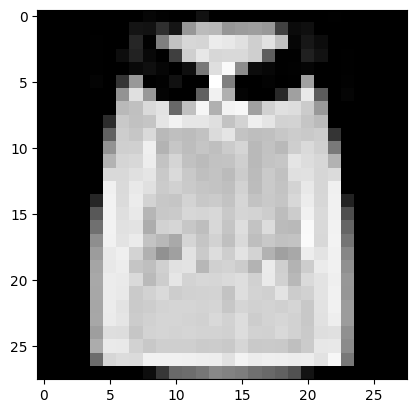

In [ ]:
plt.imshow(train[3][0].reshape(28, 28), cmap='gray');

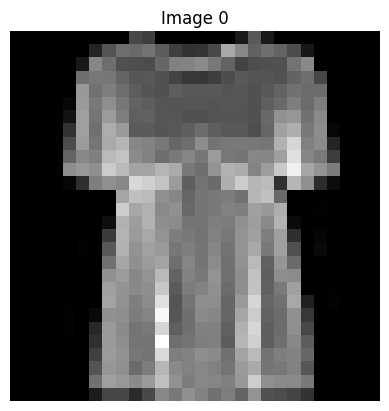

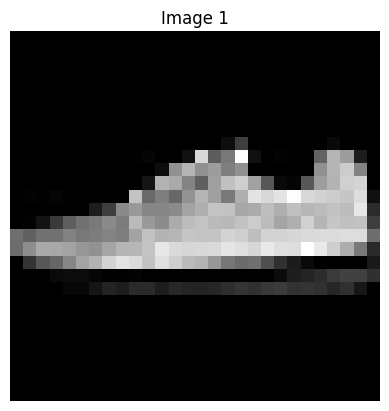

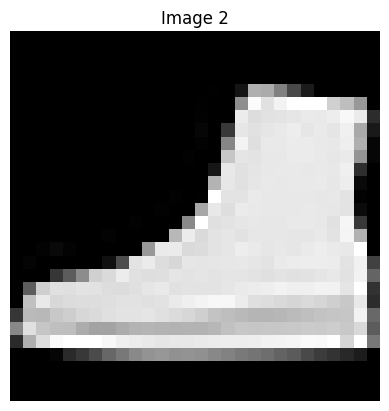

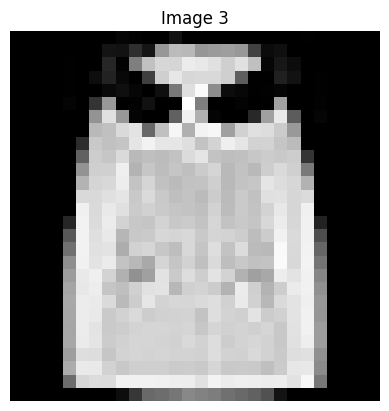

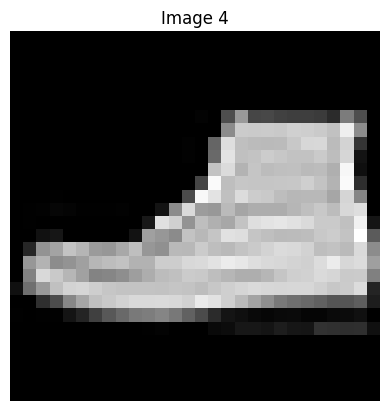

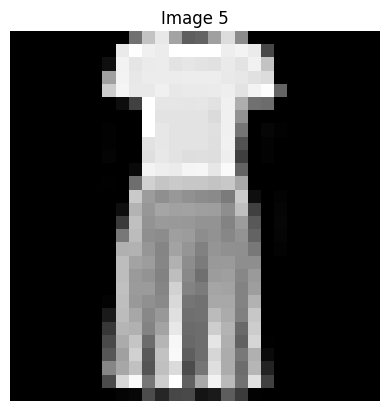

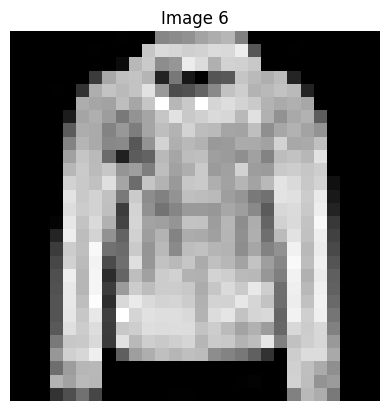

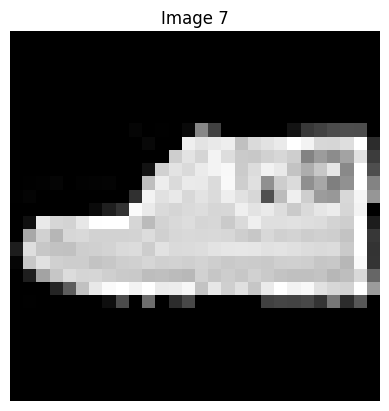

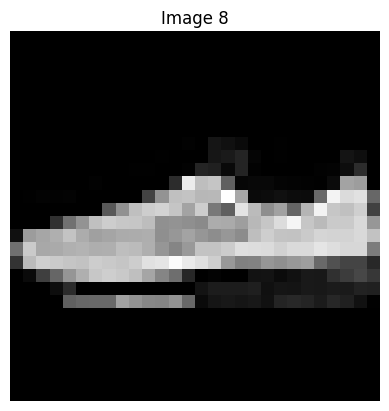

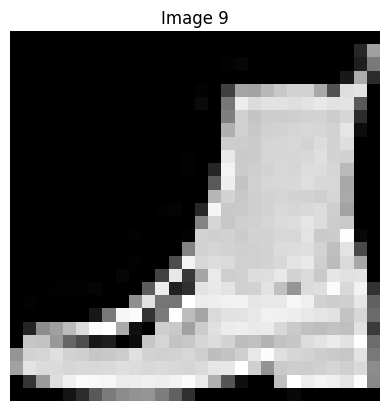

In [ ]:
for i in range(10):
    plt.figure()  # 新しい図を作成
    plt.imshow(train[i][0].reshape(28, 28), cmap='gray')
    plt.axis('off')  # 軸のラベルを非表示にする
    plt.title(f'Image {i}')  # タイトルを追加
    plt.show()